In [1]:
# EDA Exploratory Data Analysisの略らしい
# AUC Area Under the Curve ポジティブな分類とネガティブな分類の差を評価する指標 値が高いほどいいモデル 1が最高 0.5がランダム

# importするライブラリ
import warnings
warnings.filterwarnings("ignore")

import optuna # ハイパーパラメータの自動最適化フレームワーク
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# ここまでは大体テンプレ




In [24]:
# まず最初は絶対これ
train_data = pd.read_csv("./dataset/train.csv")
test_data = pd.read_csv("./dataset/test.csv")
original_data = pd.read_csv("./dataset/Rainfall.csv")

In [25]:
# sampleだとランダムに行を取ってくる
train_data.sample(5)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
1311,1311,217,1008.3,29.1,27.9,25.8,23.2,72.0,69.0,7.1,70.0,25.9,1
1255,1255,161,1009.3,31.7,29.4,27.6,25.6,84.0,86.0,1.6,190.0,21.6,1
1926,1926,102,1006.9,27.5,25.0,24.9,22.1,89.0,88.0,0.5,240.0,10.2,0
1528,1528,69,1023.8,17.2,14.8,11.7,8.4,69.0,22.0,9.0,20.0,12.5,0
144,144,145,1008.7,33.0,30.2,28.4,25.7,78.0,53.0,10.0,220.0,10.9,0


In [26]:
original_data.sample(5)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
214,2,1011.6,32.3,28.9,26.8,24.5,78,54,no,11.4,100.0,9.8
167,16,1006.7,31.4,29.4,28.2,25.9,82,88,yes,1.6,230.0,23.2
54,24,1027.5,15.5,13.7,12.3,10.0,78,88,yes,0.0,20.0,28.0
93,3,1014.6,26.5,23.0,21.0,20.7,87,88,no,2.3,50.0,9.2
15,16,1013.5,17.1,16.4,15.5,15.6,95,93,yes,0.0,60.0,40.0


In [27]:
original_data.columns

Index(['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection',
       'windspeed'],
      dtype='object')

In [28]:
# 名前の前後にある空白の削除
original_data.columns = original_data.columns.str.strip()

In [29]:
# rainfallのyes, noを1, 0に置き換え
original_data["rainfall"] = original_data["rainfall"].map({"yes": 1, "no": 0})

In [30]:
train_rows, train_columns = train_data.shape
test_rows, test_columns = test_data.shape
original_rows, original_columns = original_data.shape

print("train_data:")
print(f"Number of Rows: {train_rows}")
print(f"Number of Columns: {train_columns}")

print("train_data:")
print(f"Number of Rows: {test_rows}")
print(f"Number of Columns: {test_columns}")

print("train_data:")
print(f"Number of Rows: {original_rows}")
print(f"Number of Columns: {original_columns}")

train_data:
Number of Rows: 2190
Number of Columns: 13
train_data:
Number of Rows: 730
Number of Columns: 12
train_data:
Number of Rows: 366
Number of Columns: 12


In [31]:
# 欠損値, 固有値, データのタイプを探る
missing_values_train = pd.DataFrame({"Feature": train_data.columns,
                                     "[TRAIN] No. of Missing Values": train_data.isnull().sum().values,
                                     "[TRAIN] % of Missing Values": (train_data.isnull().sum().values) / len(train_data) * 100})
missing_values_test = pd.DataFrame({"Feature": test_data.columns,
                                     "[TEST] No. of Missing Values": test_data.isnull().sum().values,
                                     "[TEST] % of Missing Values": (test_data.isnull().sum().values) / len(test_data) * 100})
missing_values_original = pd.DataFrame({"Feature": original_data.columns,
                                     "[ORIGINAL] No. of Missing Values": original_data.isnull().sum().values,
                                     "[ORIGINAL] % of Missing Values": (original_data.isnull().sum().values) / len(original_data) * 100})

unique_values = pd.DataFrame({"Feature": train_data.columns,
                              "No. of Unique Values[FROM TRAIN]": train_data.nunique().values})
feature_types = pd.DataFrame({"Feature": train_data.columns,
                              "Datatype": train_data.dtypes })

merged_df = pd.merge(missing_values_train, missing_values_test, on="Feature", how="left")
merged_df = pd.merge(merged_df, missing_values_original, on="Feature", how="left")
merged_df = pd.merge(merged_df, unique_values, on="Feature", how="left")
merged_df = pd.merge(merged_df, feature_types, on="Feature", how="left")

merged_df.style.background_gradient(cmap="viridis")

,Feature,[TRAIN] No. of Missing Values,[TRAIN] % of Missing Values,[TEST] No. of Missing Values,[TEST] % of Missing Values,[ORIGINAL] No. of Missing Values,[ORIGINAL] % of Missing Values,No. of Unique Values[FROM TRAIN],Datatype
0,id,0,0.000000,0.000000,0.000000,nan,nan,2190,int64
1,day,0,0.000000,0.000000,0.000000,0.000000,0.000000,365,int64
2,pressure,0,0.000000,0.000000,0.000000,0.000000,0.000000,236,float64
3,maxtemp,0,0.000000,0.000000,0.000000,0.000000,0.000000,219,float64
4,temparature,0,0.000000,0.000000,0.000000,0.000000,0.000000,198,float64
5,mintemp,0,0.000000,0.000000,0.000000,0.000000,0.000000,199,float64
6,dewpoint,0,0.000000,0.000000,0.000000,0.000000,0.000000,218,float64
7,humidity,0,0.000000,0.000000,0.000000,0.000000,0.000000,49,float64
8,cloud,0,0.000000,0.000000,0.000000,0.000000,0.000000,78,float64
9,sunshine,0,0.000000,0.000000,0.000000,0.000000,0.000000,120,float64


In [33]:
original_data.head(5)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,1,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,1,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,1,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,1,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,1,0.0,40.0,13.7


In [37]:
# 重複している行がないかチェック
train_duplicates = train_data.duplicated().sum()
test_duplicates = test_data.duplicated().sum()
original_duplicates = original_data.duplicated().sum()

print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in original_data: {original_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in original_data: 0


In [40]:
# データセットの詳細な内容の確認
train_data.describe().T.style.background_gradient(cmap="viridis")

,count,mean,std,min,25%,50%,75%,max
id,2190.000000,1094.500000,632.342866,0.000000,547.250000,1094.500000,1641.750000,2189.000000
day,2190.000000,179.948402,105.203592,1.000000,89.000000,178.500000,270.000000,365.000000
pressure,2190.000000,1013.602146,5.655366,999.000000,1008.600000,1013.000000,1017.775000,1034.600000
maxtemp,2190.000000,26.365799,5.654330,10.400000,21.300000,27.800000,31.200000,36.000000
temparature,2190.000000,23.953059,5.222410,7.400000,19.300000,25.500000,28.400000,31.500000
mintemp,2190.000000,22.170091,5.059120,4.000000,17.700000,23.850000,26.400000,29.800000
dewpoint,2190.000000,20.454566,5.288406,-0.300000,16.800000,22.150000,25.000000,26.700000
humidity,2190.000000,82.036530,7.800654,39.000000,77.000000,82.000000,88.000000,98.000000
cloud,2190.000000,75.721918,18.026498,2.000000,69.000000,83.000000,88.000000,100.000000
sunshine,2190.000000,3.744429,3.626327,0.000000,0.400000,2.400000,6.800000,12.100000


In [45]:
original_data.describe().T.style.background_gradient(cmap="viridis")

,count,mean,std,min,25%,50%,75%,max
day,366.000000,183.500000,105.799338,1.000000,92.250000,183.500000,274.750000,366.000000
pressure,366.000000,1013.742623,6.414776,998.500000,1008.500000,1013.000000,1018.100000,1034.600000
maxtemp,366.000000,26.191257,5.978343,7.100000,21.200000,27.750000,31.200000,36.300000
temparature,366.000000,23.747268,5.632813,4.900000,18.825000,25.450000,28.600000,32.400000
mintemp,366.000000,21.894536,5.594153,3.100000,17.125000,23.700000,26.575000,30.000000
dewpoint,366.000000,19.989071,5.997021,-0.400000,16.125000,21.950000,25.000000,26.700000
humidity,366.000000,80.177596,10.062470,36.000000,75.000000,80.500000,87.000000,98.000000
cloud,366.000000,71.128415,21.798012,0.000000,58.000000,80.000000,88.000000,100.000000
rainfall,366.000000,0.680328,0.466988,0.000000,0.000000,1.000000,1.000000,1.000000
sunshine,366.000000,4.419399,3.934398,0.000000,0.500000,3.500000,8.200000,12.100000


In [47]:
# dayの解釈が違うから直す
original_data["day"] = range(1, len(original_data)+1)
original_data["day"].describe()

count    366.000000
mean     183.500000
std      105.799338
min        1.000000
25%       92.250000
50%      183.500000
75%      274.750000
max      366.000000
Name: day, dtype: float64

In [48]:
# ["winddirection"]は角度なので有界 -> つまりcategorical変数になる
numerical_variables = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
target_variable = 'rainfall' 
categorical_variables = ['winddirection']

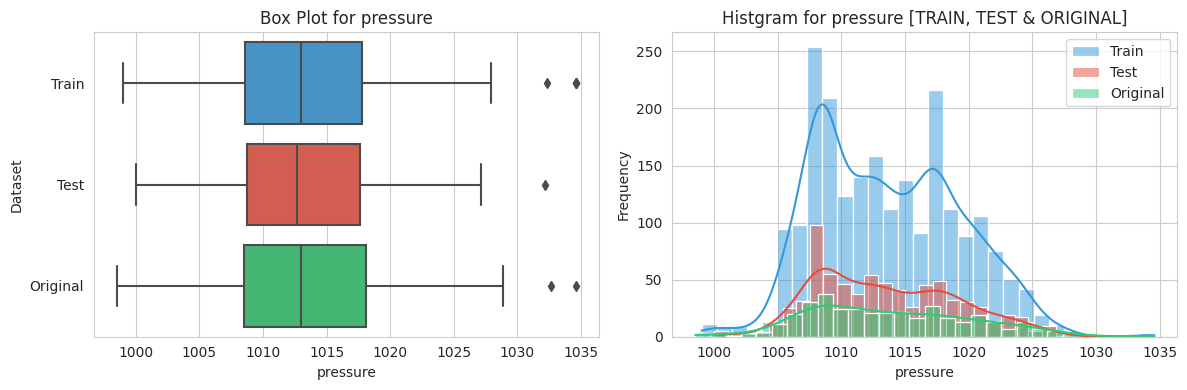

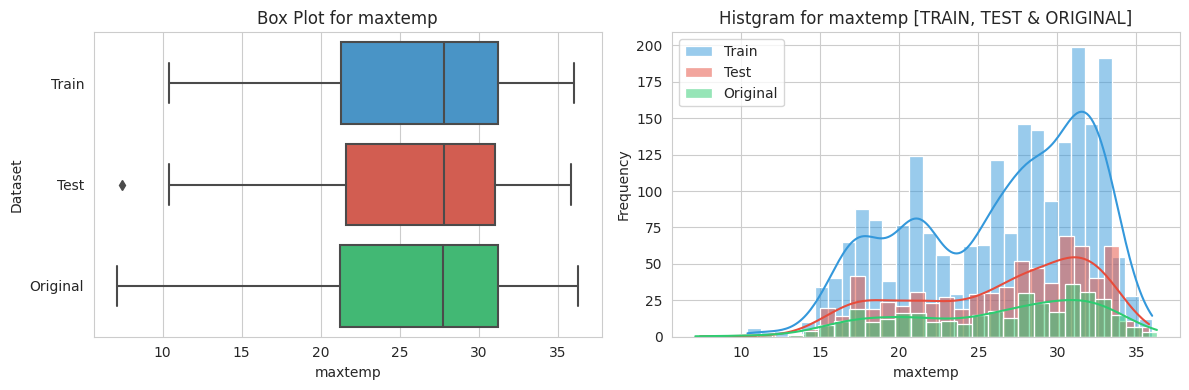

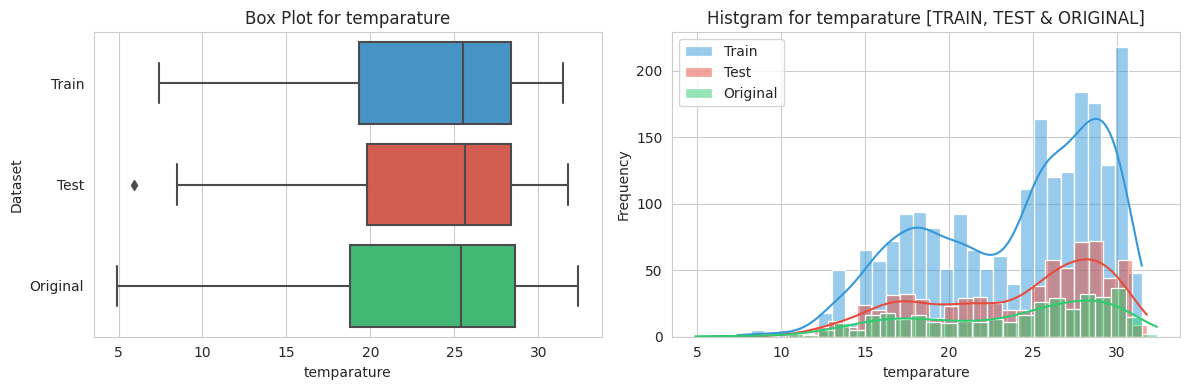

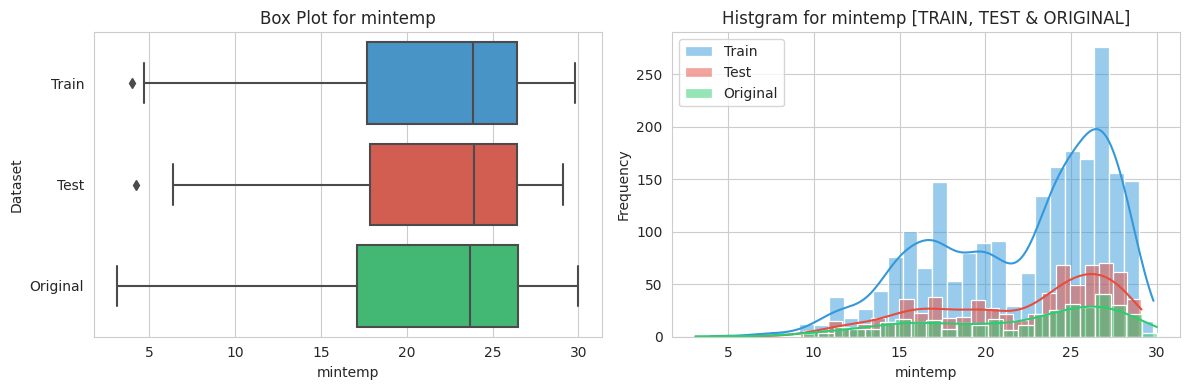

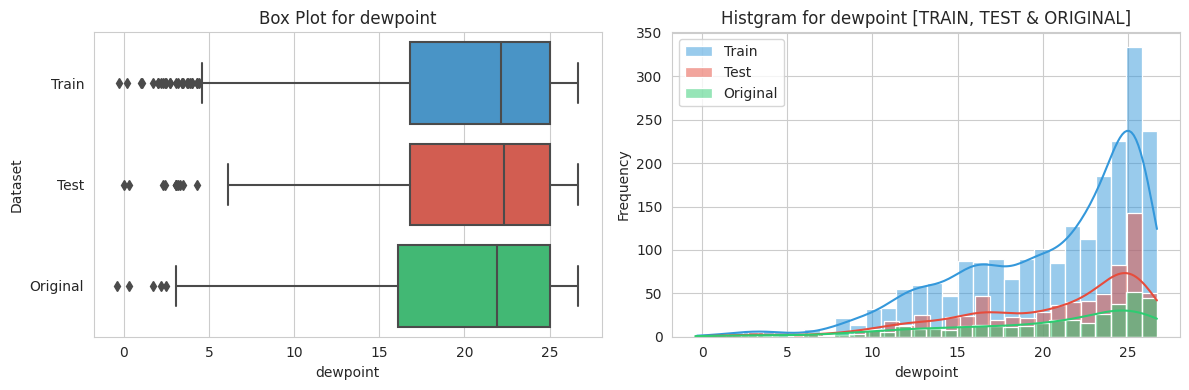

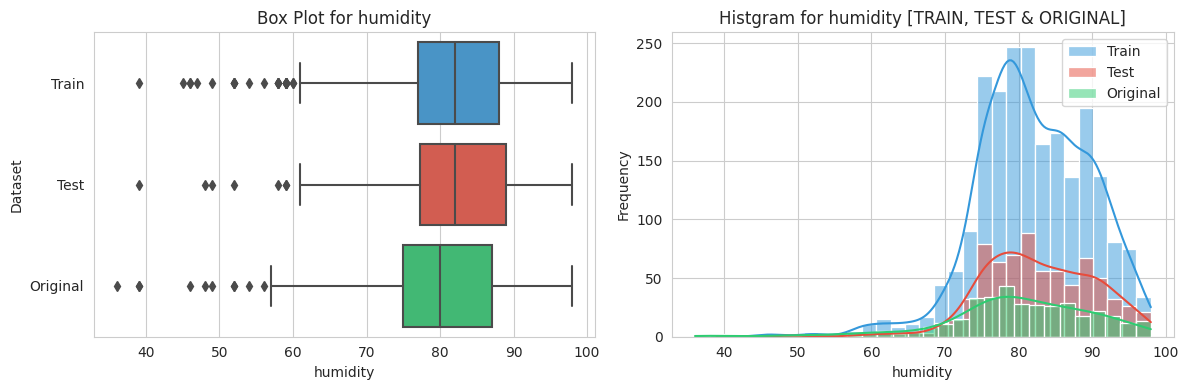

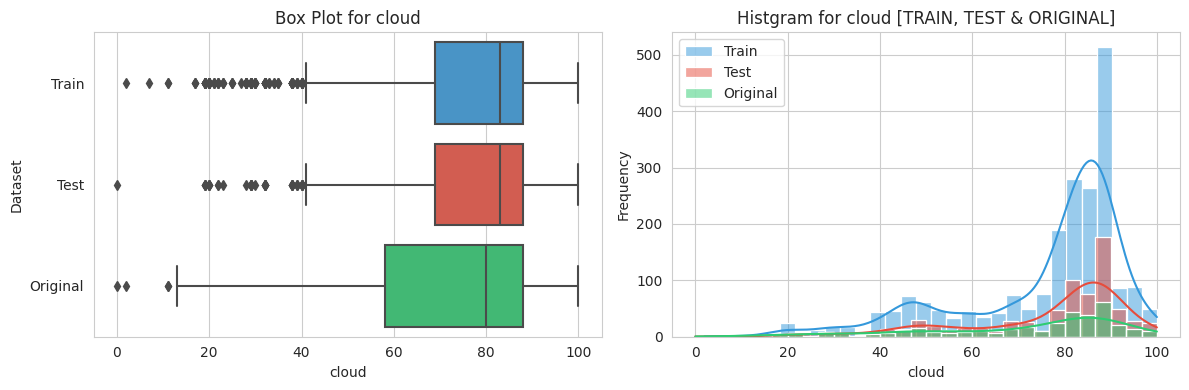

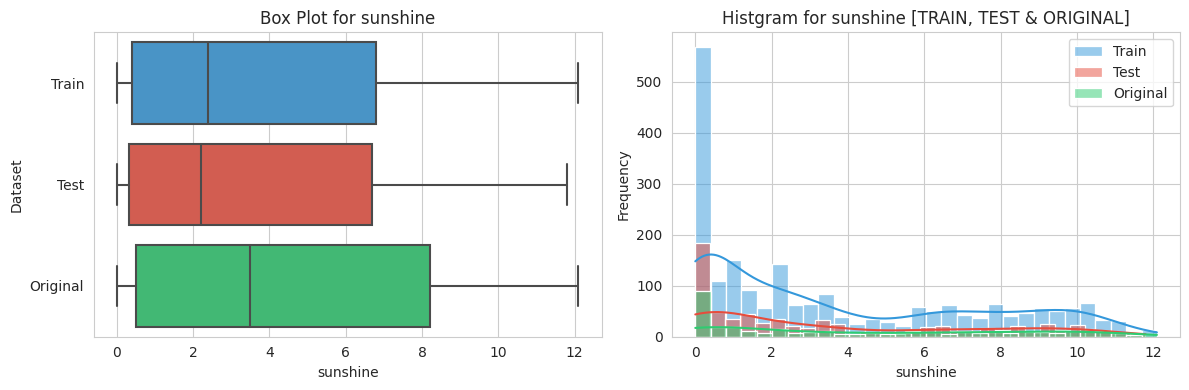

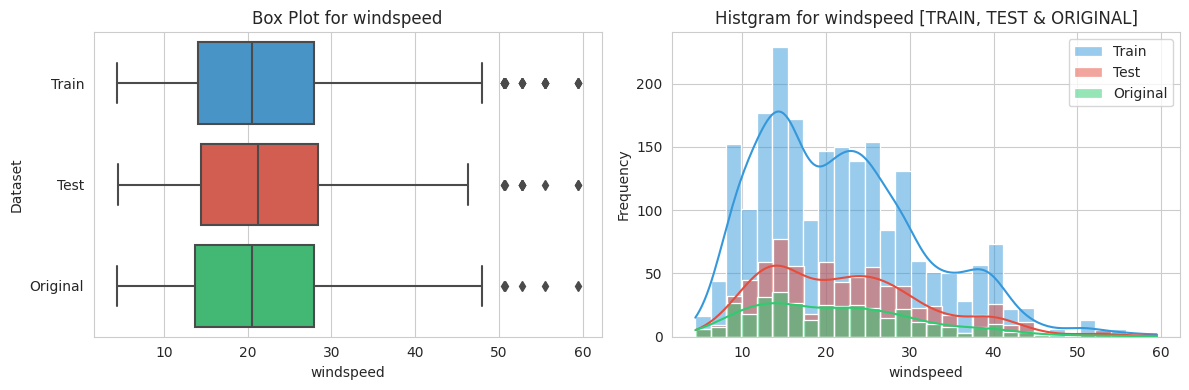

In [49]:
# データをとりあえず箱ひげ図とヒストグラムで図解
custom_palette = ['#3498db', '#e74c3c','#2ecc71']

# データセットカラムを加えて区別する(よくやる)
train_data["Dataset"] = "Train"
test_data["Dataset"] = "Test"
original_data["Dataset"] = "Original"

# 描画関数
def create_variable_plots(variable):
  sns.set_style("whitegrid")
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  
  # 箱ひげの方
  plt.subplot(1, 2, 1)
  sns.boxplot(data=pd.concat([train_data, test_data, original_data.dropna()]), x=variable, y="Dataset", palette=custom_palette)
  plt.xlabel(variable)
  plt.title(f"Box Plot for {variable}")
  
  # ヒストグラムの方
  plt.subplot(1, 2, 2)
  sns.histplot(data=train_data, x=variable, color=custom_palette[0], kde=True, bins=30, label="Train")
  sns.histplot(data=test_data, x=variable, color=custom_palette[1], kde=True, bins=30, label="Test")
  sns.histplot(data=original_data.dropna(), x=variable, color=custom_palette[2], kde=True, bins=30, label="Original")
  plt.xlabel(variable)
  plt.ylabel("Frequency")
  plt.title(f"Histgram for {variable} [TRAIN, TEST & ORIGINAL]")
  plt.legend() # 定義するときに付けたlebelから凡例を作る 
  
  # サブプロット同士のスペースを調整
  plt.tight_layout()
  
  plt.show()
  
for variable in numerical_variables:
  create_variable_plots(variable)

# Datasetカラムを落とす
train_data.drop("Dataset", axis=1, inplace=True)
test_data.drop("Dataset", axis=1, inplace=True)
original_data.drop("Dataset", axis=1, inplace=True)  
  

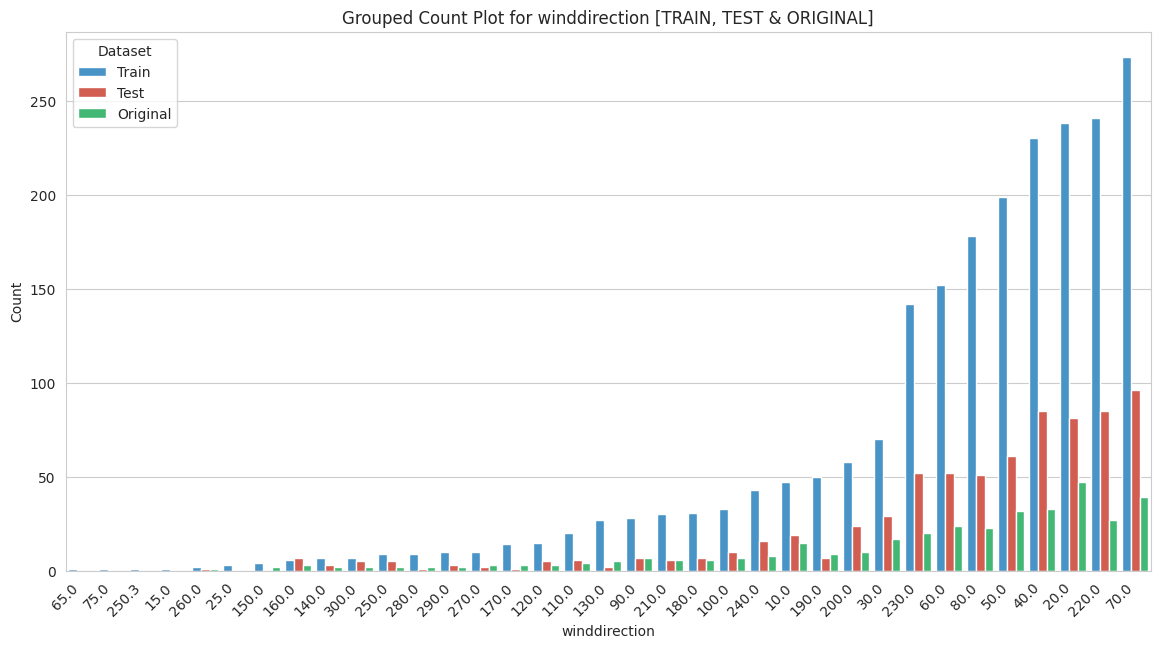

In [51]:
def create_categorical_barplot(variable):
  sns.set_style("whitegrid")
  
  train_data_copy = train_data.copy()
  test_data_copy = test_data.copy()
  original_data_copy = original_data.dropna().copy()
  
  train_data_copy["Dataset"] = "Train"
  test_data_copy["Dataset"] = "Test"
  original_data_copy["Dataset"] = "Original"
  
  combined_data = pd.concat([train_data_copy, test_data_copy, original_data_copy])
  
  # index(数値)ごとの数を集計してソート、最後にそのindexの方を返してリスト化
  train_counts = train_data[variable].value_counts().sort_values(ascending=True).index.tolist()
  
  plt.figure(figsize=(14, 7))
  sns.countplot(
    data=combined_data,
    x=variable,
    hue="Dataset",
    palette=custom_palette,
    dodge=True,
    width=0.85,
    order=train_counts
  )
  
  plt.ylabel("Count")
  plt.xlabel(variable)
  plt.title(f"Grouped Count Plot for {variable} [TRAIN, TEST & ORIGINAL]")
  plt.legend(title="Dataset")
  
  # xlabelが見にくいから回転
  plt.xticks(rotation=45, ha="right")
  
  plt.show()

for variable in categorical_variables:
  create_categorical_barplot(variable)

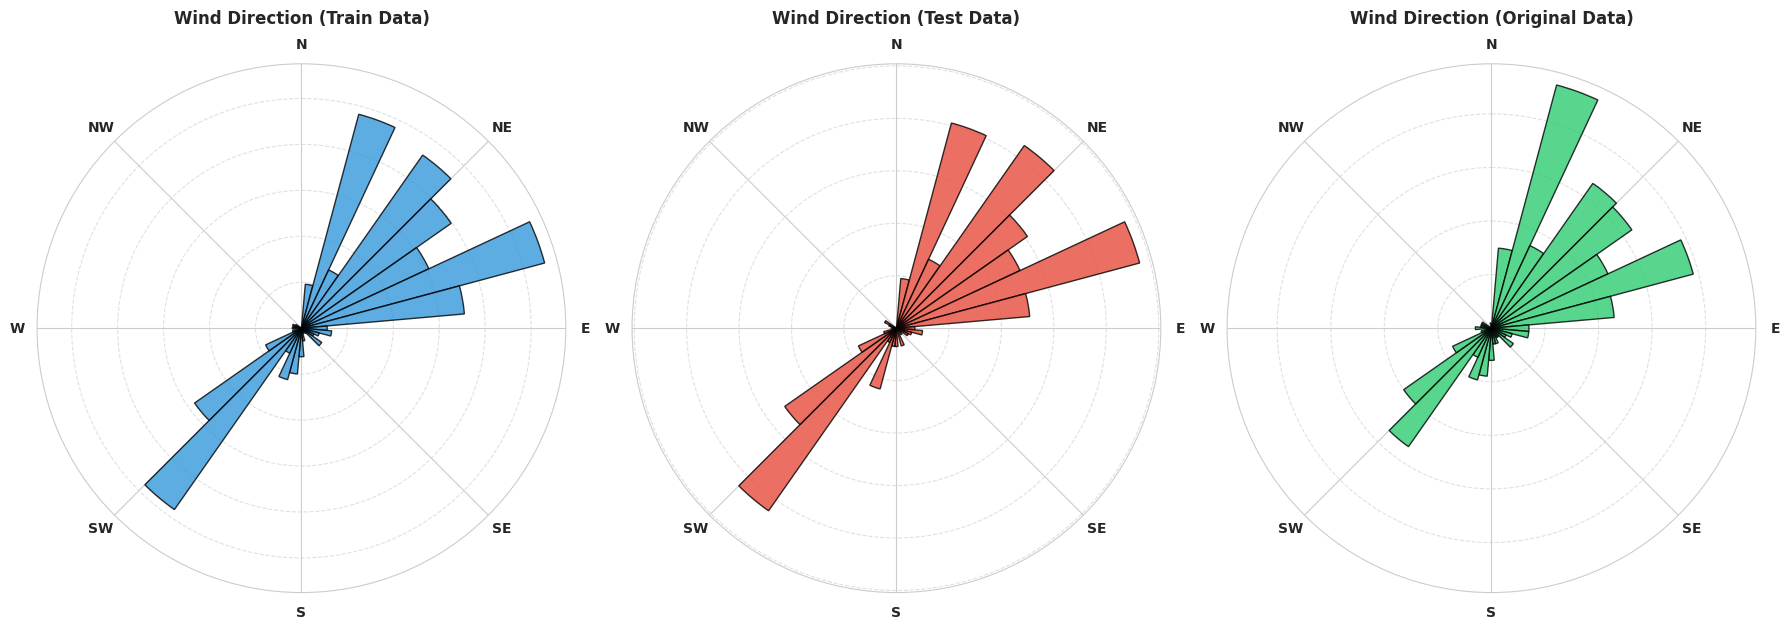

In [57]:
# 風向きを知るために円グラフに描画してみる

def create_wind_rose(ax, data, dataset_name, color):
  wind_direction_radians = np.radians(data["winddirection"].dropna())
  bins = np.linspace(0, 2*np.pi, 37)
  counts, bin_edges = np.histogram(wind_direction_radians, bins=bins)
  
  bars = ax.bar(bin_edges[:-1], counts, width=np.radians(10), color=color, edgecolor="black", alpha=0.8)
  
  ax.set_theta_zero_location("N")
  ax.set_theta_direction(-1) # 時計回り
  ax.set_xticks(np.radians(np.arange(0, 360, 45)))
  ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], fontsize=10, fontweight='bold')
  
  ax.yaxis.grid(True, linestyle="--", alpha=0.6)
  ax.set_yticklabels([])
  ax.set_title(f"Wind Direction ({dataset_name})", fontsize=12, fontweight="bold", pad=10)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection":"polar"})

create_wind_rose(axes[0], train_data, "Train Data", custom_palette[0])
create_wind_rose(axes[1], test_data, "Test Data", custom_palette[1])
create_wind_rose(axes[2], original_data.dropna(), "Original Data", custom_palette[2])

plt.tight_layout()
plt.show()

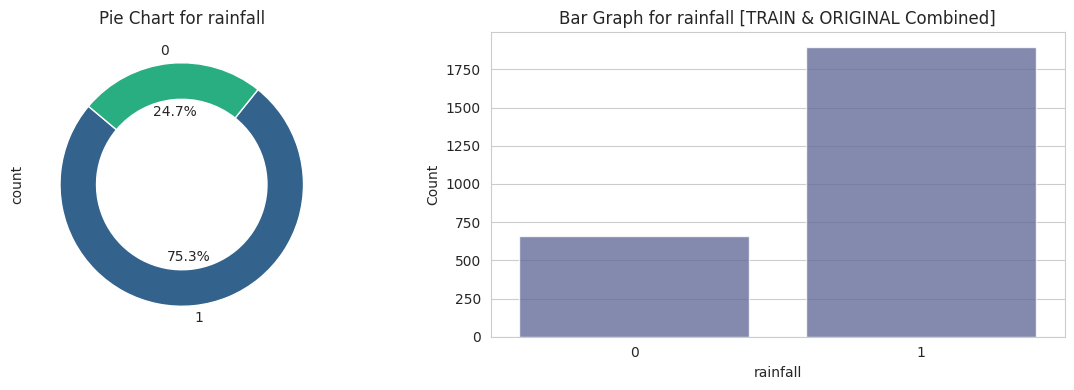

In [59]:
pie_chart_palette = ['#33638d', '#28ae80', '#d3eb0c', '#ff9a0b', '#7e03a8', '#35b779', '#fde725', '#440154', '#90d743', '#482173', '#22a884', '#f8961e']
countplot_color = '#5C67A3'

# 目的変数をプロットして分布見る
def create_target_plots(variable):
  sns.set_style("whitegrid")
  
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  
  # 円グラフ
  plt.subplot(1, 2, 1)
  train_data[variable].value_counts().plot.pie(
    autopct="%1.1f%%", colors=pie_chart_palette, wedgeprops=dict(width=0.3), startangle=140
  )
  plt.title(f"Pie Chart for {variable}")
  
  # 棒グラフ
  plt.subplot(1, 2, 2)
  sns.countplot(
    data=pd.concat([train_data, original_data.dropna()]),
    x=variable,
    color=countplot_color,
    alpha=0.8 # alphaは不透明度
  )
  plt.xlabel(variable)
  plt.ylabel("Count")
  plt.title(f"Bar Graph for {variable} [TRAIN & ORIGINAL Combined]")
  
  plt.tight_layout()
  plt.show()
  
create_target_plots(target_variable)

In [60]:
"""
つまり雨の日のデータが多いから、偏った結果になる
雨の日に向かってデータが歪んでるからそれを修正しないと雨じゃない日の予測が困難になる
"""

'\nつまり雨の日のデータが多いから、偏った結果になる\n雨の日に向かってデータが歪んでるからそれを修正しないと雨じゃない日の予測が困難になる\n'